# Dimensionality Reduction using an Autoencoder
Welcome to this project. We will introduce the theory behind an autoencoder (AE), its uses, and its advantages over PCA, a common dimensionality reduction technique.

## Some Prerequisites
- Basic-to-intermediate level understanding of Python
- Basic theory of neural networks is beneficial, but not required

## Project Outline
[**Task 1**](#task1): Package Importing and Introduction to Project

[**Task 2**](#task2): Dataset Creation and Preprocessing

[**Task 3**](#task3): Create a Baseline Model with PCA

[**Task 4**](#task4): Autoencoder Introduction and Training

[**Task 5**](#task5): Reducing Dimensionality with AE

<a id='task1'></a>
# Task 1: Importing and Introduction

In [45]:
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [46]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [47]:
colors = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='task2'></a>
# Task 2: Dataset Creation and Preprocessing

In [48]:
X, y = make_blobs(n_samples    = 20000,
                  n_features   = 50,
                  centers      = 20,
                  cluster_std  = 0.2,
                  center_box   = (-1.0, 1.0),
                  random_state = 17)

In [71]:
display(X.shape)
display(y.shape)

(20000, 50)

(20000,)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 17)

In [73]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

<a id='task3'></a>
# Task 3: Baseline Model

In [120]:
pca = PCA(n_components = 2)

pca.fit(X_train)
X_test_pca = pca.transform(X_test)

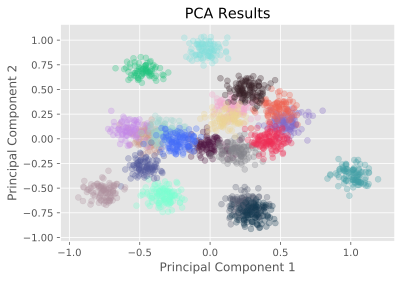

In [121]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    X_data = X_test_pca[y_test==label]
    
    plt.scatter(X_data[:,0], X_data[:,1], alpha=0.3, c=colors[index])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA Results')
plt.show()

<a id='task4'></a>
# Task 4: Autoencoder Theory and Training
![title](Images/ae_viz.pdf)

https://blog.keras.io/building-autoencoders-in-keras.html

In [123]:
autoencoder = MLPRegressor(hidden_layer_sizes=(50,100,75,50,2,50,75,100,50),
                           alpha=1e-15,
                           batch_size=batch_size,
                           max_iter=25000,
                           random_state=None)

autoencoder.fit(X_train, X_train)

MLPRegressor(activation='relu', alpha=1e-15, batch_size=64, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(50, 100, 75, 50, 2, 50, 75, 100, 50),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=25000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
             verbose=False, warm_start=False)

<a id='task5'></a>
# Task 5: Reducing Dimensionality with Encoder

In [124]:
W = autoencoder.coefs_
biases = autoencoder.intercepts_

In [125]:
for w in W:
    print(w.shape)

(50, 50)
(50, 100)
(100, 75)
(75, 50)
(50, 2)
(2, 50)
(50, 75)
(75, 100)
(100, 50)
(50, 50)


In [126]:
encoder_weights = W[0:5]
encoder_biases = biases[0:5]

In [127]:
def encode(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w,b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b
        else:
            res_ae = np.maximum(0, res_ae@w+b)
            
    return res_ae

In [128]:
res_AE = encode(encoder_weights, encoder_biases, X_test) # (2000, 2)

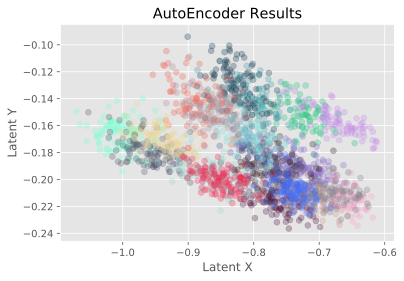

In [129]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = res_AE[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [98]:
silhouette_score(X_test, y_test)

0.6106327445141103

In [130]:
silhouette_score(X_test_pca, y_test)

0.36442758897195726

In [132]:
silhouette_score(res_AE, y_test)

-0.011343192626649828

0.37888703

## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

- https://blog.keras.io/building-autoencoders-in-keras.html
- https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/
- https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

### Encoder

In [138]:
# this is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_size = 50

# this is our input placeholder 50,100,75,50,2
input_img = Input(shape=(input_size,))
# x = Dropout(0.20)(input_img)
# x = LeakyReLU(alpha=0.1)(x)
# x = BatchNormalization()(input_img)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(input_img)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

encoded = Dense(encoding_dim, activation='relu')(x)

# this model maps an input to its encoded representation 
encoder = Model(input_img, encoded, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               5100      
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 100)               400       
_________________________________________________________________
dense_65 (Dense)             (None, 75)                7575      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 75)                0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 75)                300 

### Decoder

In [139]:
# create a placeholder for an encoded (32-dimensional) 2,50,75,100,50
latent_space = Input(shape=(encoding_dim,), name='DecoderLayerInput')

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(latent_space)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

decoded_output = Dense(input_size, activation='sigmoid', name='DecoderLayerOut')(x)

# create the decoder model
decoder = Model(latent_space, decoded_output, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DecoderLayerInput (InputLaye [(None, 2)]               0         
_________________________________________________________________
dense_68 (Dense)             (None, 50)                150       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 50)                200       
_________________________________________________________________
dense_69 (Dense)             (None, 75)                3825      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 75)                0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 75)                300 

### Autoencoder

In [140]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
Encoder (Model)              (None, 2)                 17477     
_________________________________________________________________
Decoder (Model)              (None, 50)                20275     
Total params: 37,752
Trainable params: 36,752
Non-trainable params: 1,000
_________________________________________________________________


In [142]:
autoencoder.compile(optimizer='adam', # Or adadelta
                    loss='binary_crossentropy') #binary_crossentropy/mse

### Train AutoEncoder

Now let's train our autoencoder to reconstruct MNIST digits. First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [21]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [22]:
(x_train, _), (x_test, _) = mnist.load_data()

# We will normalize all values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [76]:
print(X_train.shape)
print(X_test.shape)

(18000, 50)
(2000, 50)


In [143]:
epochs = 50
batch_size=64

History = autoencoder.fit(X_train, X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test))

Train on 18000 samples, validate on 2000 samples
Epoch 1/50
18000/18000 [==============================] - 6s 319us/sample - loss: 0.7153 - val_loss: 0.7172
Epoch 2/50
18000/18000 [==============================] - 3s 150us/sample - loss: 0.6948 - val_loss: 0.7282
Epoch 3/50
18000/18000 [==============================] - 3s 150us/sample - loss: 0.6913 - val_loss: 0.6975
Epoch 4/50
18000/18000 [==============================] - 3s 150us/sample - loss: 0.6876 - val_loss: 0.7190
Epoch 5/50
18000/18000 [==============================] - 3s 150us/sample - loss: 0.6871 - val_loss: 0.6981
Epoch 6/50
18000/18000 [==============================] - 3s 150us/sample - loss: 0.6837 - val_loss: 0.7275
Epoch 7/50
18000/18000 [==============================] - 3s 151us/sample - loss: 0.6812 - val_loss: 0.7079
Epoch 8/50
18000/18000 [==============================] - 3s 149us/sample - loss: 0.6794 - val_loss: 0.7016
Epoch 9/50
18000/18000 [==============================] - 3s 152us/sample - loss: 0.678

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.092

### Encode-Decode 
Encode and decode some digits

In [144]:
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)

decoded_imgs = decoder.predict(encoded_imgs)

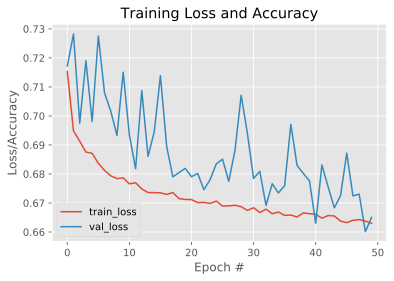

In [146]:
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History.history["loss"], label="train_loss")
plt.plot(N, History.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

We can try to visualize the reconstructed inputs and the encoded representations.

ValueError: cannot reshape array of size 2 into shape (8,4)

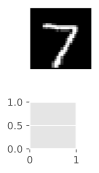

In [100]:
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images    
    ax = plt.subplot(3, n, 2*20+i + 1 )
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

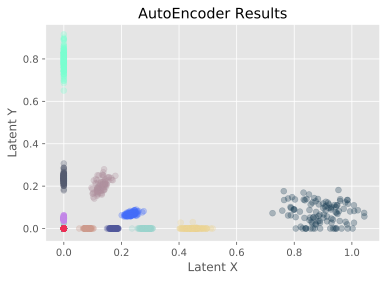

In [147]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = encoded_imgs[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [149]:
silhouette_score(encoded_imgs, y_test)

0.37888703